In [ ]:
pip install rfpimp

  Preparing metadata (setup.py) ... done
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10649 sha256=799568321423837573d5a715ce735d1724f2ad413e94b6d92724d5658da7abdd
  Stored in directory: /root/.cache/pip/wheels/6a/12/08/d5bc35127c8d69d39c1f3736a95419ab4763cc0c80ed65bf41
Successfully built rfpimp


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MaxAbsScaler
import pandas as pd
import matplotlib.pyplot as plt
import sklearn


# CART
from sklearn.tree import DecisionTreeRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor

# feature importance
import rfpimp

# xgboost
import xgboost
from xgboost import XGBRegressor

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [ ]:
# check the library version before we start
print("xgboost version:{}".format(xgboost.__version__))
print("sklearn version:{}".format(sklearn.__version__))

xgboost version:1.7.6
sklearn version:1.2.2


## **1. Data processing**

In [ ]:
import numpy as np

df = pd.read_csv('Cycling/GOV_Selected_3/10_Cycle_All Accident_Street View_Accident Rate_A&S.csv')


# 3. 将'accident_rate_1'列的数值从0到1分成三个等距区间，并用1、2、3来表示类别
num_bins = 3
bins = np.linspace(0, 1, num_bins + 1)  # 等距分为三个区间
labels = [1, 2, 3]  # 对应的类别标签

# 4. 更新DataFrame中'accident_rate_1'列的数值为新的类别
df['accident_rate_category'] = pd.cut(df['accident_rate'], bins=bins, labels=labels, include_lowest=True)


print(df)

df.to_csv("Cycling/GOV_Selected_3/10_Cycle_All Accident_Street View_Accident Rate_A&S_category.csv", index=False)

In [ ]:
clean = pd.read_csv('Cycling/GOV_Selected_3/10_Cycle_All Accident_Street View_Accident Rate_A&S_category.csv', dtype={'enclosure ratio': float,'cycling suitability index': float,'signage density index': float})

clean.info()

In [ ]:
# 定义转换关系
replace_dict = {1:3, 2: 3, 3: 1}

# 替换accident_severity的值
clean['adjusted_severity'] = clean['accident_severity'].replace(replace_dict)

# 乘以accident_rate_category
clean['weighted_accident_rate'] = clean['accident_rate_category'] * clean['adjusted_severity']

print(clean)

In [ ]:
# 定义转换关系
replace_dict = { 1:2, 3:2, 4:3, 6: 3, 9:3}

# 替换accident_severity的值
clean['adjusted_weighted_accident_rate'] = clean['weighted_accident_rate'].replace(replace_dict)

print(clean)

In [ ]:
clean.to_csv("Cycling/GOV_Selected_3/10_Cycle_All Accident_Street View_Weighted Accident Rate_A&S_category.csv", index=False)

In [ ]:
clean = pd.read_csv('Cycling/GOV_Selected_3/10_Cycle_All Accident_Street View_Weighted Accident Rate_A&S_category.csv')

print(clean)
clean.info()

       motorcycle  terrain  traffic sign  bicycle    road  traffic light  \
0               0   440810             0      178  324592              0   
1               0   482161             0      106  317154              0   
2               0   451739             0        0  333316              0   
3               0   386349            34        0  386917              0   
4               0        0          3581        0    6412              0   
...           ...      ...           ...      ...     ...            ...   
21405           0        0             0      253       0              0   
21406           0        0           237        0       0              0   
21407           0        0           111        0       9              0   
21408           0        0             0        0       0              0   
21409           0        0             0        0       0              0   

       openness ratio  pole  greenery coverage    fence  ...  \
0              514443  

## **2. Treating streetscape factors as a percentage.**

In [ ]:
import pandas as pd

# 1. 读取数据集
clean = pd.read_csv('Cycling/GOV_Selected_3/10_Cycle_All Accident_Street View_Weighted Accident Rate_A&S_category.csv')

# 2. 修改选定列的名称
cols_to_modify = list(range(0,6)) + [7] + list(range(9,18))
for col in cols_to_modify:
    clean.columns.values[col] = "proportion of the " + clean.columns.values[col]

# 3. 更新选定列的值
clean.iloc[:, 0:18] = clean.iloc[:, 0:18].div(1638400)

print(clean)
clean.info()

                  proportion of the motorcycle  \
0                                       0.0000   
1                                       0.0000   
2                                       0.0000   
3                                       0.0000   
4                                       0.0000   
...                                        ...   
21405                                   0.0000   
21406                                   0.0000   
21407                                   0.0000   
21408                                   0.0000   
21409                                   0.0000   

                     proportion of the terrain  \
0                                       0.2690   
1                                       0.2943   
2                                       0.2757   
3                                       0.2358   
4                                       0.0000   
...                                        ...   
21405                                   0.0000   

In [ ]:
clean.to_csv("Cycling/GOV_Selected_3/10_Cycle_All Accident_Street View_Weighted Accident Rate_A&S_proportion.csv", index=False)

In [ ]:
columns_to_drop = ['pedestrian_crossing_physical_facilities', 'junction_location', 
                   'carriageway_hazards', 'trunk_road_flag', 'closest_road_length', 
                   'accidents', 'all accident counts', 'accident_rate', 
                   'accident_rate_category', 'accident_severity', 
                   'adjusted_severity', 'weighted_accident_rate']

# Dropping the specified columns
clean = clean.drop(columns=columns_to_drop)

# Renaming the column
clean = clean.rename(columns={'adjusted_weighted_accident_rate': 'Cycling_Safety_Level'})

# Saving the resulting DataFrame to a CSV file
clean_dropped.to_csv("Cycling/GOV_Selected_3/Cycling Safety Level.csv", index=False)


## **3. SMOTE**

In [ ]:
random_state_split = 100

train_x, test_x, train_y, test_y = train_test_split(clean.drop(['Cycling_Safety_Level'], axis = 1), clean['Cycling_Safety_Level'], random_state=random_state_split)


In [ ]:
from imblearn.over_sampling import SMOTE

# 假设多数类有6000个样本，少数类有4000个样本，希望将少数类的样本增加到多数类的90%。
sampling_ratio = 0.9

# 使用SMOTE进行过采样
sm = SMOTE(sampling_strategy=sampling_ratio, random_state=random_state_split)
train_x_resampled, train_y_resampled = sm.fit_resample(train_x, train_y)


# 使用SMOTE进行过采样
sm = SMOTE(sampling_strategy=sampling_ratio, random_state=random_state_split)
test_x_resampled, test_y_resampled = sm.fit_resample(test_x, test_y)

In [ ]:
# 打印过采样前后的类别计数
print("Before SMOTE:", train_y.value_counts())
print("After SMOTE:", train_y_resampled.value_counts())

print("Before SMOTE:", test_y.value_counts())
print("After SMOTE:", test_y_resampled.value_counts())

Before SMOTE: 2    13896
3     2161
Name: adjusted_weighted_accident_rate, dtype: int64
After SMOTE: 2    13896
3    12506
Name: adjusted_weighted_accident_rate, dtype: int64
Before SMOTE: 2    4620
3     733
Name: adjusted_weighted_accident_rate, dtype: int64
After SMOTE: 2    4620
3    4158
Name: adjusted_weighted_accident_rate, dtype: int64


In [ ]:
print(train_x_resampled.shape)
print(train_y_resampled.shape)
print(test_x_resampled.shape)
print(test_y_resampled.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.

print(train_x_resampled.index.identical(train_y_resampled.index))
print(test_x.index.identical(test_y.index))

(26402, 32)
(26402,)
(8778, 32)
(8778,)
True
True


## **4.1. Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier


# 使用默认设置的CART
cart_default = DecisionTreeClassifier(random_state=0)
cart_default.fit(train_x_resampled, train_y_resampled)
##cart_default.fit(train_x, train_y)
print("Tree depth: {}".format(cart_default.get_depth()))

Tree depth: 31


In [ ]:
# 设置超参数
hyperparameters = {'max_depth':[8,10,12,14,16], 'min_samples_split':[18,20,22,24,26]}
randomState_dt = 10000
dt = DecisionTreeClassifier(random_state=randomState_dt)

# 网格搜索
clf = GridSearchCV(dt, hyperparameters)
clf.fit(train_x_resampled, train_y_resampled)
##clf.fit(train_x, train_y)

# 网格搜索 with 5-fold 交叉验证
##clf = GridSearchCV(dt, hyperparameters, cv=10)
##clf.fit(train_x_resampled, train_y_resampled)

print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 14, 'min_samples_split': 22}
The best score is: 
0.8034678277759607


In [ ]:
# 使用最佳参数训练模型
dt_final = DecisionTreeClassifier(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
dt_final.fit(train_x_resampled, train_y_resampled)
##dt_final.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=14, min_samples_split=22, random_state=10000)

In [ ]:
print("R2 on the training data:")
print(dt_final.score(X=train_x_resampled, y=train_y_resampled))
print("R2 on the testing data:")
print(dt_final.score(X=test_x_resampled, y=test_y_resampled))

R2 on the training data:
0.8603136126051056
R2 on the testing data:
0.7950558213716108


Precision: 0.807981475697038
Recall: 0.7892255892255893
F1 Score: 0.7901883746138596
Accuracy: 0.7950558213716108


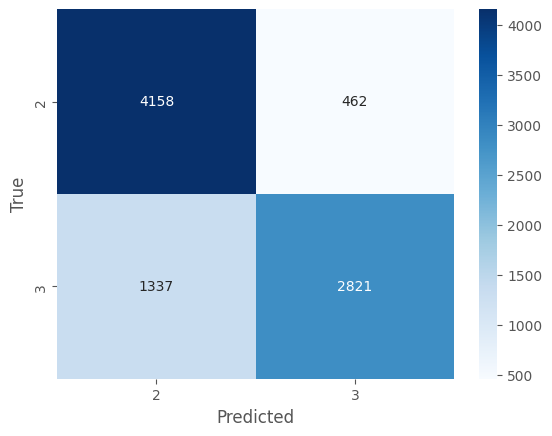

In [ ]:
import numpy as np
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred = dt_final.predict(test_x_resampled)
##y_pred = dt_final.predict(test_x)

# Convert predictions to classes
y_pred_classes = y_pred.round().astype(int)

# Convert continuous targets to binary targets
test_y_classes = test_y_resampled.round().astype(int)
##test_y_classes = test_y.round().astype(int)

# Calculate precision, recall, and F1 score with a multiclass metric
precision = precision_score(test_y_classes, y_pred_classes, average='macro')
recall = recall_score(test_y_classes, y_pred_classes, average='macro')
f1 = f1_score(test_y_classes, y_pred_classes, average='macro')
accuracy = accuracy_score(test_y_resampled, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

# Generate and print the confusion matrix
unique_labels = np.unique(test_y_resampled)
##unique_labels = np.unique(test_y)
cm = confusion_matrix(test_y_classes, y_pred_classes, labels=unique_labels)
# define the class labels
class_names = unique_labels

# plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# set plot labels
plt.xlabel('Predicted')
plt.ylabel('True')

# show the plot
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

unique_labels = np.unique(test_y_resampled)
##unique_labels = np.unique(test_y)

# make predictions on test data
predictions = dt_final.predict(test_x_resampled)
##predictions = dt_final.predict(test_x)

# calculate the classification report for each accident_severity value
accident_severity_values = unique_labels
for value in accident_severity_values:
    target_test = (test_y_resampled == value)
    ##target_test = (test_y == value)
    target_pred = (predictions == value)
    print(f"Classification Report for Weighted Accident Rate={value}:")
    print(classification_report(target_test, target_pred))
    precision = precision_score(target_test, target_pred)
    recall = recall_score(target_test, target_pred)
    f1 = f1_score(target_test, target_pred)
    accuracy = accuracy_score(target_test, target_pred)
    tn, fp, fn, tp = confusion_matrix(target_test, target_pred).ravel()
    specificity = tn / (tn + fp)
    print(f"Precision for Weighted Accident Rate={value}: {precision:.2f}")
    print(f"Recall for Weighted Accident Rate={value}: {recall:.2f}")
    print(f"F1-score for Weighted Accident Rate={value}: {f1:.2f}")
    print(f"Accuracy for Weighted Accident Rate={value}: {accuracy:.2f}")
    print(f"Specificity for Weighted Accident Rate={value}: {specificity:.2f}")

Classification Report for Weighted Accident Rate=2:
              precision    recall  f1-score   support

       False       0.86      0.68      0.76      4158
        True       0.76      0.90      0.82      4620

    accuracy                           0.80      8778
   macro avg       0.81      0.79      0.79      8778
weighted avg       0.81      0.80      0.79      8778

Precision for Weighted Accident Rate=2: 0.76
Recall for Weighted Accident Rate=2: 0.90
F1-score for Weighted Accident Rate=2: 0.82
Accuracy for Weighted Accident Rate=2: 0.80
Specificity for Weighted Accident Rate=2: 0.68
Classification Report for Weighted Accident Rate=3:
              precision    recall  f1-score   support

       False       0.76      0.90      0.82      4620
        True       0.86      0.68      0.76      4158

    accuracy                           0.80      8778
   macro avg       0.81      0.79      0.79      8778
weighted avg       0.81      0.80      0.79      8778

Precision for Weight

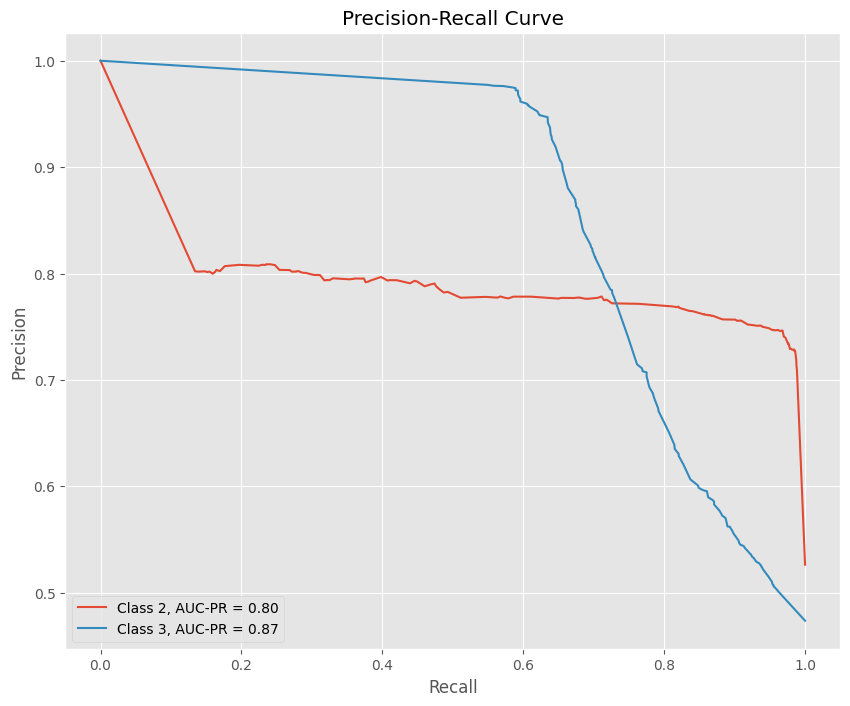

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# 预测概率，因为AUC-PR需要概率值而不是类标签
probs = dt_final.predict_proba(test_x_resampled)

# 初始化图形
plt.figure(figsize=(10, 8))

# 为每个标签计算Precision-Recall曲线和AUC-PR
for value in unique_labels:
    # 获取这个标签的真实值（1为当前标签，0为其他标签）
    target_test = (test_y_resampled == value)
    # 获取当前标签的预测概率
    prob = probs[:, np.where(dt_final.classes_ == value)[0][0]]
    # 计算Precision-Recall曲线
    precision, recall, thresholds = precision_recall_curve(target_test, prob)
    # 计算AUC-PR
    pr_auc = auc(recall, precision)
    # 绘制Precision-Recall曲线
    plt.plot(recall, precision, label=f'Class {value}, AUC-PR = {pr_auc:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

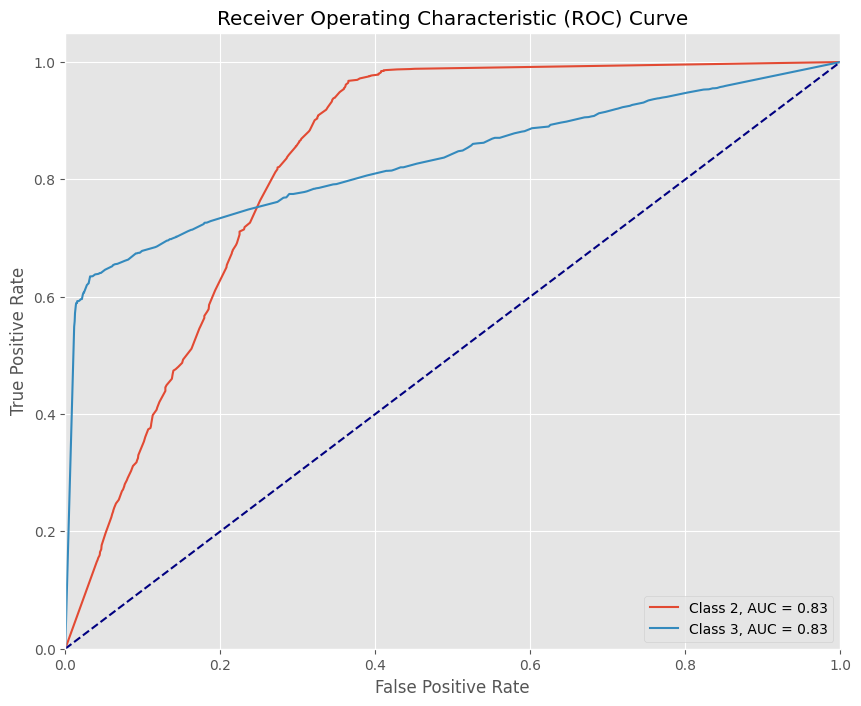

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# 预测概率，因为ROC和AUC需要概率值而不是类标签
probs = dt_final.predict_proba(test_x_resampled)

# 初始化图形
plt.figure(figsize=(10,8))

# 为每个标签计算ROC和AUC
for value in unique_labels:
    # 获取这个标签的真实值（1为当前标签，0为其他标签）
    target_test = (test_y_resampled == value).astype(int)
    # 获取当前标签的预测概率
    prob = probs[:, np.where(dt_final.classes_ == value)[0][0]]
    # 计算ROC曲线
    fpr, tpr, thresholds = roc_curve(target_test, prob)
    # 计算AUC
    roc_auc = auc(fpr, tpr)
    # 绘制ROC曲线
    plt.plot(fpr, tpr, label=f'Class {value}, AUC = {roc_auc:.2f}')

# 添加基线
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

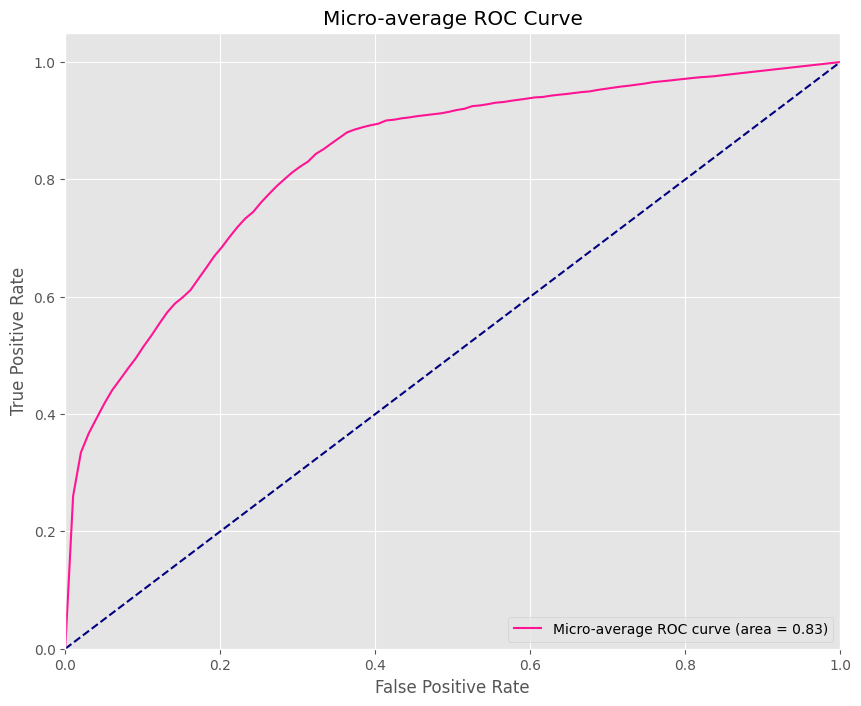

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# 预测概率，因为ROC和AUC需要概率值而不是类标签
probs = dt_final.predict_proba(test_x_resampled)

# 计算微平均ROC
all_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0
n_classes = len(unique_labels)

for value in unique_labels:
    target_test = (test_y_resampled == value).astype(int)
    ##prob = probs[:, np.where(dt_final.classes_ == value)[0][0]]
    prob = probs[:, np.where(dt_final.classes_ == value)[0][0]]
    fpr, tpr, thresholds = roc_curve(target_test, prob)
    mean_tpr += np.interp(all_fpr, fpr, tpr)

mean_tpr /= n_classes



# 计算AUC
micro_auc = auc(all_fpr, mean_tpr)

# 绘图
plt.figure(figsize=(10,8))
plt.plot(all_fpr, mean_tpr, label=f'Micro-average ROC curve (area = {micro_auc:0.2f})', color='deeppink')

# 添加基线
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")
plt.show()


## **4.2. Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestClassifier(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters)

clf.fit(train_x_resampled, train_y_resampled)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 30, 'min_samples_split': 2}
The best score is: 
0.9097867211214588


In [ ]:
rf_final = RandomForestClassifier(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
rf_final.fit(train_x_resampled, train_y_resampled)

RandomForestClassifier(max_depth=30, random_state=10000)

In [ ]:
print("R2 on the training data:")
print(rf_final.score(X=train_x_resampled, y=train_y_resampled))
print("R2 on the testing data:")
print(rf_final.score(X=test_x_resampled, y=test_y_resampled))

R2 on the training data:
1.0
R2 on the testing data:
0.8250170881749829


Precision: 0.8586687628358538
Recall: 0.8168109668109669
F1 Score: 0.8178089282031126
Accuracy: 0.8250170881749829


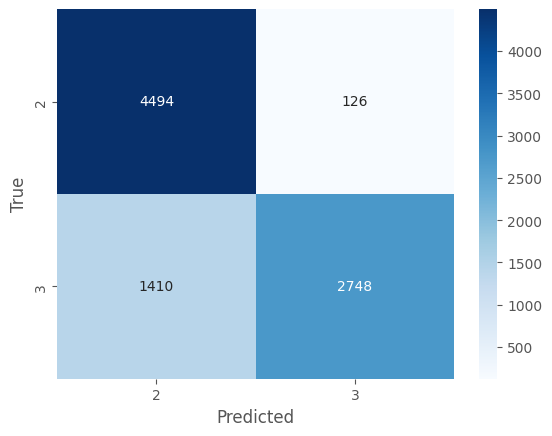

In [ ]:
import numpy as np
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred = rf_final.predict(test_x_resampled)
##y_pred = dt_final.predict(test_x)

# Convert predictions to classes
y_pred_classes = y_pred.round().astype(int)

# Convert continuous targets to binary targets
test_y_classes = test_y_resampled.round().astype(int)
##test_y_classes = test_y.round().astype(int)

# Calculate precision, recall, and F1 score with a multiclass metric
precision = precision_score(test_y_classes, y_pred_classes, average='macro')
recall = recall_score(test_y_classes, y_pred_classes, average='macro')
f1 = f1_score(test_y_classes, y_pred_classes, average='macro')
accuracy = accuracy_score(test_y_resampled, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

# Generate and print the confusion matrix
unique_labels = np.unique(test_y_resampled)
##unique_labels = np.unique(test_y)
cm = confusion_matrix(test_y_classes, y_pred_classes, labels=unique_labels)
# define the class labels
class_names = unique_labels

# plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# set plot labels
plt.xlabel('Predicted')
plt.ylabel('True')

# show the plot
plt.show()

In [ ]:
print("R2 on the training data:")
print(xgb_final.score(X=train_x_resampled, y=train_y_resampled))
print("R2 on the testing data:")
print(xgb_final.score(X=test_x_resampled, y=test_y_resampled))

R2 on the training data:
1.0
R2 on the testing data:
0.8341756919374248


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# 设置您希望尝试的阈值
threshold = 0.8

unique_labels = np.unique(test_y_resampled)
##unique_labels = np.unique(test_y)

# make predictions on test data
predictions = rf_final.predict(test_x_resampled)
##predictions = dt_final.predict(test_x)

# calculate the classification report for each accident_severity value
accident_severity_values = unique_labels
for value in accident_severity_values:
    target_test = (test_y_resampled == value)
    ##target_test = (test_y == value)
    target_pred = (predictions == value)
    print(f"Classification Report for Weighted Accident Rate={value}:")
    print(classification_report(target_test, target_pred))
    precision = precision_score(target_test, target_pred)
    recall = recall_score(target_test, target_pred)
    f1 = f1_score(target_test, target_pred)
    accuracy = accuracy_score(target_test, target_pred)
    tn, fp, fn, tp = confusion_matrix(target_test, target_pred).ravel()
    specificity = tn / (tn + fp)
    print(f"Precision for Weighted Accident Rate={value}: {precision:.2f}")
    print(f"Recall for Weighted Accident Rate={value}: {recall:.2f}")
    print(f"F1-score for Weighted Accident Rate={value}: {f1:.2f}")
    print(f"Accuracy for Weighted Accident Rate={value}: {accuracy:.2f}")
    print(f"Specificity for Weighted Accident Rate={value}: {specificity:.2f}")

Classification Report for Weighted Accident Rate=2:
              precision    recall  f1-score   support

       False       0.96      0.66      0.78      4158
        True       0.76      0.97      0.85      4620

    accuracy                           0.83      8778
   macro avg       0.86      0.82      0.82      8778
weighted avg       0.85      0.83      0.82      8778

Precision for Weighted Accident Rate=2: 0.76
Recall for Weighted Accident Rate=2: 0.97
F1-score for Weighted Accident Rate=2: 0.85
Accuracy for Weighted Accident Rate=2: 0.83
Specificity for Weighted Accident Rate=2: 0.66
Classification Report for Weighted Accident Rate=3:
              precision    recall  f1-score   support

       False       0.76      0.97      0.85      4620
        True       0.96      0.66      0.78      4158

    accuracy                           0.83      8778
   macro avg       0.86      0.82      0.82      8778
weighted avg       0.85      0.83      0.82      8778

Precision for Weight

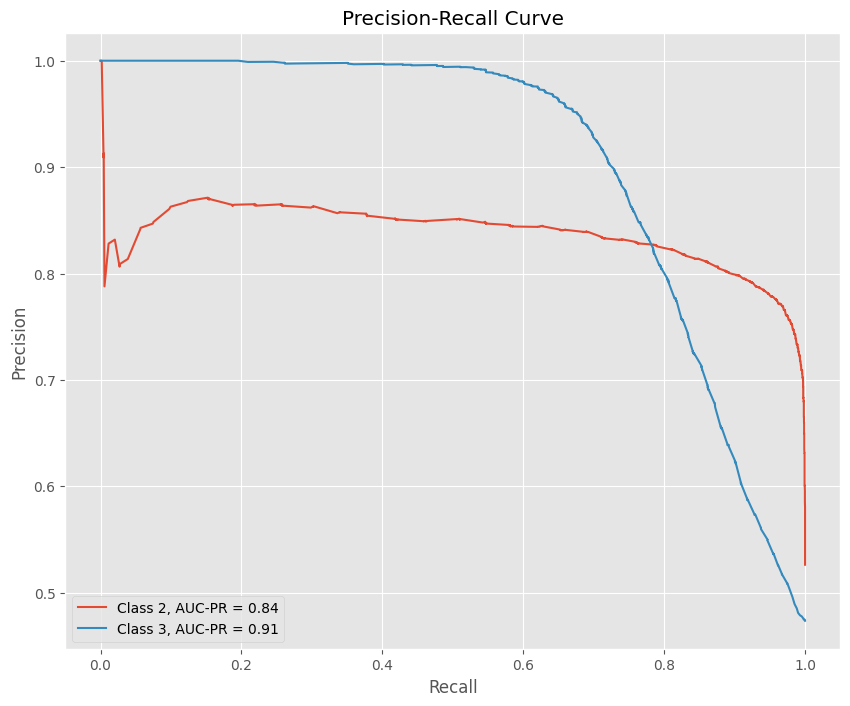

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# 预测概率，因为AUC-PR需要概率值而不是类标签
probs = rf_final.predict_proba(test_x_resampled)

# 初始化图形
plt.figure(figsize=(10, 8))

# 为每个标签计算Precision-Recall曲线和AUC-PR
for value in unique_labels:
    # 获取这个标签的真实值（1为当前标签，0为其他标签）
    target_test = (test_y_resampled == value)
    # 获取当前标签的预测概率
    prob = probs[:, np.where(dt_final.classes_ == value)[0][0]]
    # 计算Precision-Recall曲线
    precision, recall, thresholds = precision_recall_curve(target_test, prob)
    # 计算AUC-PR
    pr_auc = auc(recall, precision)
    # 绘制Precision-Recall曲线
    plt.plot(recall, precision, label=f'Class {value}, AUC-PR = {pr_auc:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

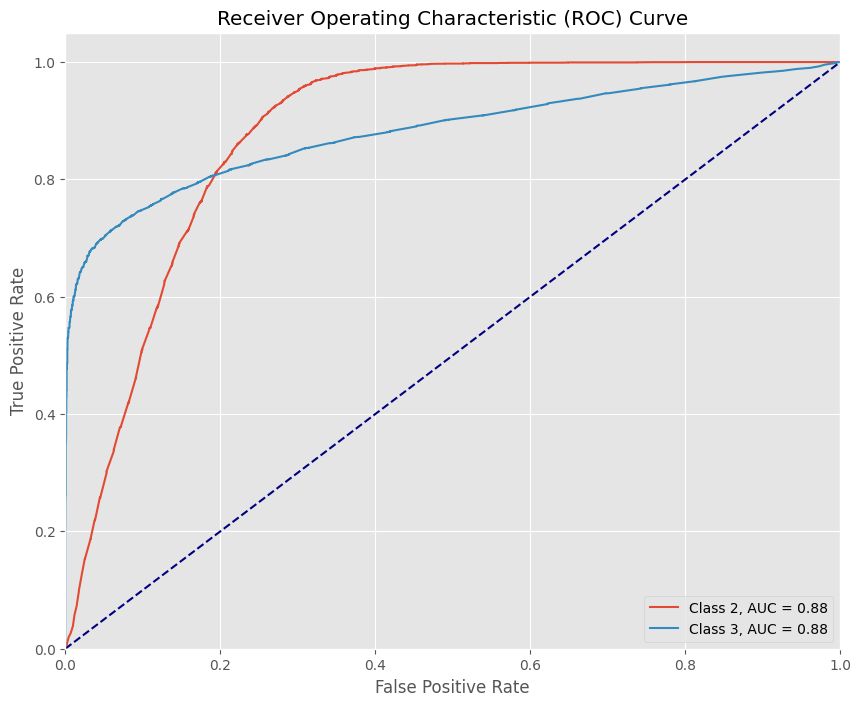

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# 预测概率，因为ROC和AUC需要概率值而不是类标签
probs = rf_final.predict_proba(test_x_resampled)

# 初始化图形
plt.figure(figsize=(10,8))

# 为每个标签计算ROC和AUC
for value in unique_labels:
    # 获取这个标签的真实值（1为当前标签，0为其他标签）
    target_test = (test_y_resampled == value).astype(int)
    # 获取当前标签的预测概率
    prob = probs[:, np.where(dt_final.classes_ == value)[0][0]]
    # 计算ROC曲线
    fpr, tpr, thresholds = roc_curve(target_test, prob)
    # 计算AUC
    roc_auc = auc(fpr, tpr)
    # 绘制ROC曲线
    plt.plot(fpr, tpr, label=f'Class {value}, AUC = {roc_auc:.2f}')

# 添加基线
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

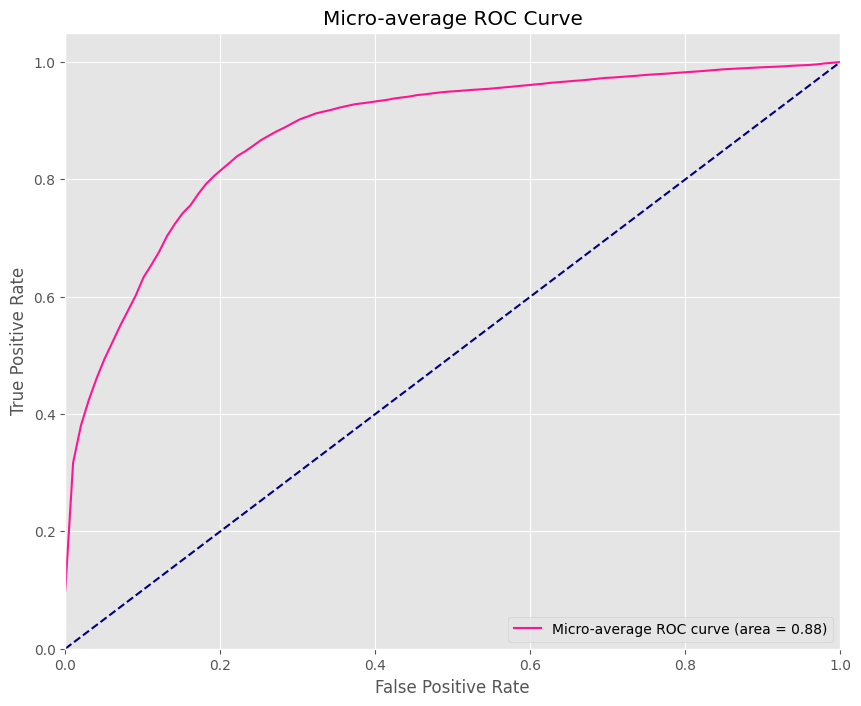

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# 预测概率，因为ROC和AUC需要概率值而不是类标签
probs = rf_final.predict_proba(test_x_resampled)

# 计算微平均ROC
all_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0
n_classes = len(unique_labels)

for value in unique_labels:
    target_test = (test_y_resampled == value).astype(int)
    prob = probs[:, np.where(rf_final.classes_ == value)[0][0]]
    fpr, tpr, thresholds = roc_curve(target_test, prob)
    mean_tpr += np.interp(all_fpr, fpr, tpr)

mean_tpr /= n_classes

# 计算AUC
micro_auc = auc(all_fpr, mean_tpr)

# 绘图
plt.figure(figsize=(10,8))
plt.plot(all_fpr, mean_tpr, label=f'Micro-average ROC curve (area = {micro_auc:0.2f})', color='deeppink')

# 添加基线
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")
plt.show()


## **4.3. XGBoost**

In [ ]:
pip install xgboost

In [ ]:
import xgboost
from xgboost import XGBClassifier

In [ ]:
import pandas as pd

# 读取数据
clean2 = pd.read_csv('Cycling/GOV_Selected_3/10_Cycle_All Accident_Street View_Weighted Accident Rate_A&S_category.csv')

# 2. 修改选定列的名称
cols_to_modify = list(range(0,6)) + [7] + list(range(9,18))
for col in cols_to_modify:
    clean2.columns.values[col] = "proportion of the " + clean2.columns.values[col]

# 随机抽取1000行
sampled_clean = clean2.sample(n=10000, random_state=42)  # random_state是种子值，保证每次随机的结果是一样的

print(sampled_clean)
sampled_clean.info()

       proportion of the motorcycle  proportion of the terrain  \
1201                            499                     119247   
5186                              0                       1869   
12157                          3121                       1788   
7883                              0                          0   
12656                             0                          0   
...                             ...                        ...   
1758                              0                       2606   
14887                           494                          0   
7644                            177                         63   
3680                           1826                          0   
15347                           921                       3563   

       proportion of the traffic sign  proportion of the bicycle  \
1201                             3303                       7597   
5186                              860                         18   
121

In [ ]:
random_state_split = 100

train_x, test_x, train_y, test_y = train_test_split(sampled_clean.drop(['pedestrian_crossing_physical_facilities','junction_location','carriageway_hazards','trunk_road_flag','closest_road_length','accidents','all accident counts','accident_rate','accident_rate_category','accident_severity','adjusted_severity','weighted_accident_rate','adjusted_weighted_accident_rate'], axis = 1), sampled_clean['adjusted_weighted_accident_rate'], random_state=random_state_split)


In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'n_estimators':[50,100,150,200,250]}

randomState_xgb = 125
xgb = XGBClassifier(random_state=randomState_xgb)

# cv=5 by default, which means 5-fold cross-validation
gscv_xgb = GridSearchCV(xgb, hyperparameters)

gscv_xgb.fit(train_x_resampled, train_y_resampled)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (gscv_xgb.best_params_)
print ("The best score is: ")
print (gscv_xgb.best_score_)

The best parameter value is: 
{'max_depth': 20, 'n_estimators': 250}
The best score is: 
0.9139478078335956


In [ ]:
from imblearn.over_sampling import SMOTE

# 假设多数类有6000个样本，少数类有4000个样本，你希望将少数类的样本增加到多数类的70%。
sampling_ratio = 0.9

# 使用SMOTE进行过采样
sm = SMOTE(sampling_strategy=sampling_ratio, random_state=random_state_split)
train_x_resampled, train_y_resampled = sm.fit_resample(train_x, train_y)


# 使用SMOTE进行过采样
sm = SMOTE(sampling_strategy=sampling_ratio, random_state=random_state_split)
test_x_resampled, test_y_resampled = sm.fit_resample(test_x, test_y)

In [ ]:
# 打印过采样前后的类别计数
print("Before SMOTE:", train_y.value_counts())
print("After SMOTE:", train_y_resampled.value_counts())

print("Before SMOTE:", test_y.value_counts())
print("After SMOTE:", test_y_resampled.value_counts())

Before SMOTE: 2    6489
3    1011
Name: adjusted_weighted_accident_rate, dtype: int64
After SMOTE: 2    6489
3    5840
Name: adjusted_weighted_accident_rate, dtype: int64
Before SMOTE: 2    2187
3     313
Name: adjusted_weighted_accident_rate, dtype: int64
After SMOTE: 2    2187
3    1968
Name: adjusted_weighted_accident_rate, dtype: int64


In [ ]:
train_y_resampled = train_y_resampled.map({2: 0, 3: 1})
test_y_resampled = test_y_resampled.map({2: 0, 3: 1})

In [ ]:
xgb_final = XGBClassifier(max_depth=gscv_xgb.best_params_['max_depth'], n_estimators=gscv_xgb.best_params_['n_estimators'], random_state=randomState_xgb)
xgb_final.fit(train_x_resampled, train_y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=125, ...)

Precision: 0.8646701234334633
Recall: 0.8264502269508291
F1 Score: 0.8279562558124511
Accuracy: 0.8341756919374248


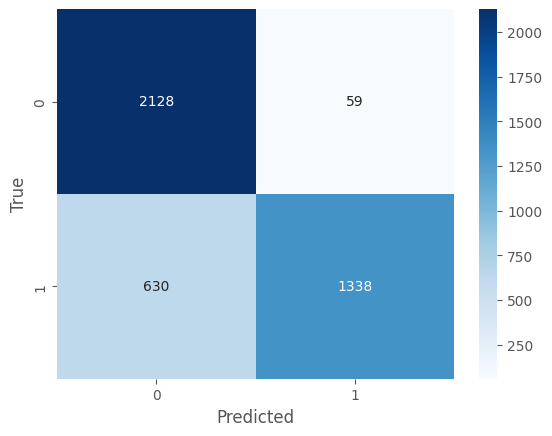

In [ ]:
import numpy as np
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred = xgb_final.predict(test_x_resampled)
##y_pred = dt_final.predict(test_x)

# Convert predictions to classes
y_pred_classes = y_pred.round().astype(int)

# Convert continuous targets to binary targets
test_y_classes = test_y_resampled.round().astype(int)
##test_y_classes = test_y.round().astype(int)

# Calculate precision, recall, and F1 score with a multiclass metric
precision = precision_score(test_y_classes, y_pred_classes, average='macro')
recall = recall_score(test_y_classes, y_pred_classes, average='macro')
f1 = f1_score(test_y_classes, y_pred_classes, average='macro')
accuracy = accuracy_score(test_y_resampled, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

# Generate and print the confusion matrix
unique_labels = np.unique(test_y_resampled)
##unique_labels = np.unique(test_y)
cm = confusion_matrix(test_y_classes, y_pred_classes, labels=unique_labels)
# define the class labels
class_names = unique_labels

# plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# set plot labels
plt.xlabel('Predicted')
plt.ylabel('True')

# show the plot
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

unique_labels = np.unique(test_y_resampled)
##unique_labels = np.unique(test_y)

# make predictions on test data
predictions = xgb_final.predict(test_x_resampled)
##predictions = dt_final.predict(test_x)

# calculate the classification report for each accident_severity value
accident_severity_values = unique_labels
for value in accident_severity_values:
    target_test = (test_y_resampled == value)
    ##target_test = (test_y == value)
    target_pred = (predictions == value)
    print(f"Classification Report for Weighted Accident Rate={value}:")
    print(classification_report(target_test, target_pred))
    precision = precision_score(target_test, target_pred)
    recall = recall_score(target_test, target_pred)
    f1 = f1_score(target_test, target_pred)
    accuracy = accuracy_score(target_test, target_pred)
    tn, fp, fn, tp = confusion_matrix(target_test, target_pred).ravel()
    specificity = tn / (tn + fp)
    print(f"Precision for Weighted Accident Rate={value}: {precision:.2f}")
    print(f"Recall for Weighted Accident Rate={value}: {recall:.2f}")
    print(f"F1-score for Weighted Accident Rate={value}: {f1:.2f}")
    print(f"Accuracy for Weighted Accident Rate={value}: {accuracy:.2f}")
    print(f"Specificity for Weighted Accident Rate={value}: {specificity:.2f}")

Classification Report for Weighted Accident Rate=0:
              precision    recall  f1-score   support

       False       0.96      0.68      0.80      1968
        True       0.77      0.97      0.86      2187

    accuracy                           0.83      4155
   macro avg       0.86      0.83      0.83      4155
weighted avg       0.86      0.83      0.83      4155

Precision for Weighted Accident Rate=0: 0.77
Recall for Weighted Accident Rate=0: 0.97
F1-score for Weighted Accident Rate=0: 0.86
Accuracy for Weighted Accident Rate=0: 0.83
Specificity for Weighted Accident Rate=0: 0.68
Classification Report for Weighted Accident Rate=1:
              precision    recall  f1-score   support

       False       0.77      0.97      0.86      2187
        True       0.96      0.68      0.80      1968

    accuracy                           0.83      4155
   macro avg       0.86      0.83      0.83      4155
weighted avg       0.86      0.83      0.83      4155

Precision for Weight

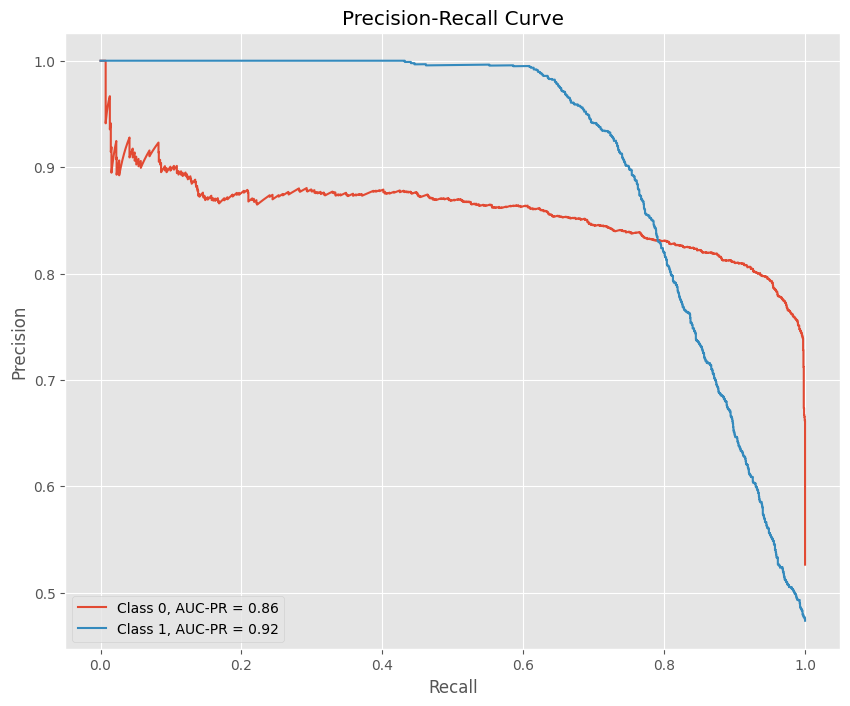

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# 预测概率，因为AUC-PR需要概率值而不是类标签
probs = xgb_final.predict_proba(test_x_resampled)

# 初始化图形
plt.figure(figsize=(10, 8))

# 为每个标签计算Precision-Recall曲线和AUC-PR
for value in unique_labels:
    # 获取这个标签的真实值（1为当前标签，0为其他标签）
    target_test = (test_y_resampled == value)
    # 获取当前标签的预测概率
    prob = probs[:, np.where(xgb_final.classes_ == value)[0][0]]
    # 计算Precision-Recall曲线
    precision, recall, thresholds = precision_recall_curve(target_test, prob)
    # 计算AUC-PR
    pr_auc = auc(recall, precision)
    # 绘制Precision-Recall曲线
    plt.plot(recall, precision, label=f'Class {value}, AUC-PR = {pr_auc:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

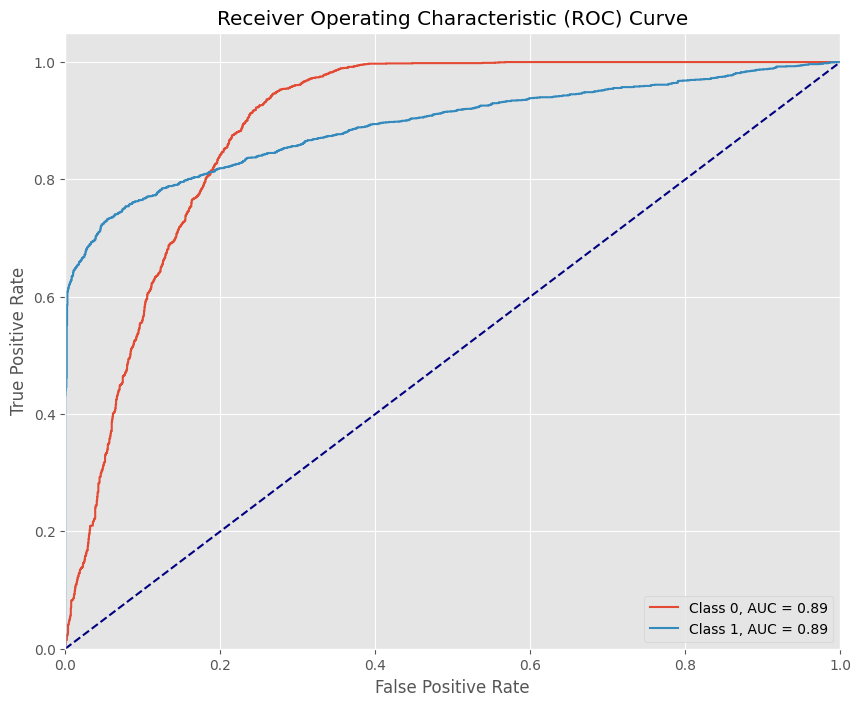

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# 预测概率，因为ROC和AUC需要概率值而不是类标签
probs = xgb_final.predict_proba(test_x_resampled)

# 初始化图形
plt.figure(figsize=(10,8))

# 为每个标签计算ROC和AUC
for value in unique_labels:
    # 获取这个标签的真实值（1为当前标签，0为其他标签）
    target_test = (test_y_resampled == value).astype(int)
    # 获取当前标签的预测概率
    prob = probs[:, np.where(xgb_final.classes_ == value)[0][0]]
    # 计算ROC曲线
    fpr, tpr, thresholds = roc_curve(target_test, prob)
    # 计算AUC
    roc_auc = auc(fpr, tpr)
    # 绘制ROC曲线
    plt.plot(fpr, tpr, label=f'Class {value}, AUC = {roc_auc:.2f}')

# 添加基线
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

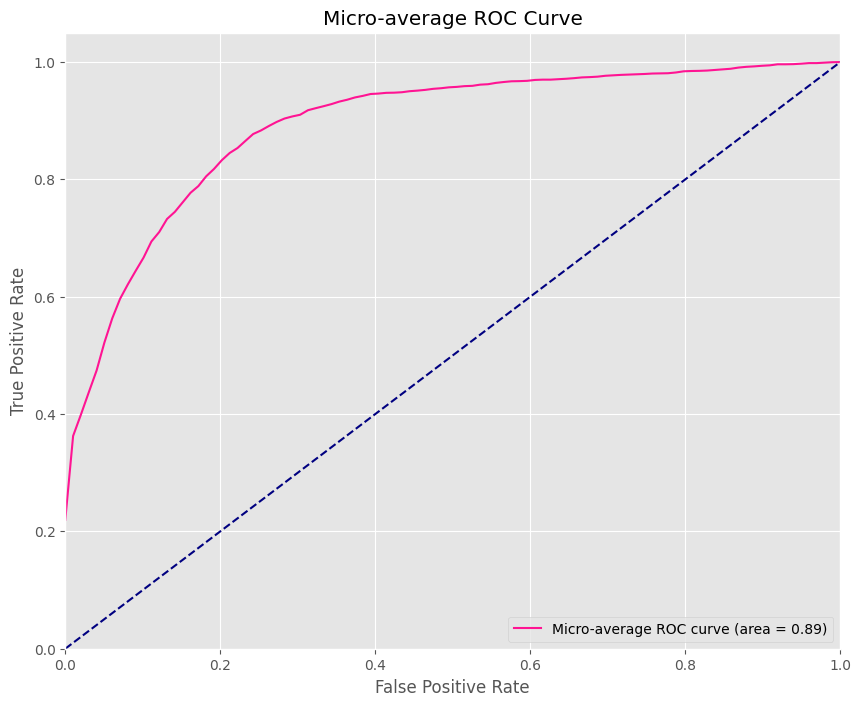

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# 预测概率，因为ROC和AUC需要概率值而不是类标签
probs = xgb_final.predict_proba(test_x_resampled)

# 计算微平均ROC
all_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0
n_classes = len(unique_labels)

for value in unique_labels:
    target_test = (test_y_resampled == value).astype(int)
    prob = probs[:, np.where(xgb_final.classes_ == value)[0][0]]
    fpr, tpr, thresholds = roc_curve(target_test, prob)
    mean_tpr += np.interp(all_fpr, fpr, tpr)

mean_tpr /= n_classes

# 计算AUC
micro_auc = auc(all_fpr, mean_tpr)

# 绘图
plt.figure(figsize=(10,8))
plt.plot(all_fpr, mean_tpr, label=f'Micro-average ROC curve (area = {micro_auc:0.2f})', color='deeppink')

# 添加基线
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")
plt.show()


## **5. SHAP**

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 9.5 MB/s eta 0:00:00a 0:00:01


In [ ]:

import shap
import pandas as pd
import numpy as np

# 假设你已经导入了 train_x_resampled, test_x_resampled, train_y_resampled, test_y_resampled 和 dt_final 数据

combined_features = pd.concat([train_x_resampled, test_x_resampled], ignore_index=True)
combined_labels = pd.concat([train_y_resampled, test_y_resampled], ignore_index=True)

# 初始化Tree解释器
explainer = shap.TreeExplainer(dt_final)


# 计算SHAP值
shap_values = explainer.shap_values(combined_features)

# 对于二分类，获取正类的SHAP值
positive_class_shap_values = shap_values[1] if len(shap_values) == 2 else None

# 计算每个特征的平均SHAP值
mean_shap_values = positive_class_shap_values.mean(axis=0)

# 将结果与特征名组合
feature_names = combined_features.columns
shap_importance = pd.Series(mean_shap_values, index=feature_names).sort_values(ascending=False)

print(shap_importance)



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


second_road_class                                                   0.0180
junction_detail                                                     0.0029
road_type                                                           0.0021
day_of_week                                                         0.0010
proportion of the pole                                              0.0005
proportion of the motorcycle                                        0.0004
proportion of the truck                                             0.0003
proportion of the road                                              0.0003
proportion of the terrain                                           0.0002
signage density index                                               0.0002
proportion of the traffic light                                     0.0001
openness ratio                                                      0.0001
special_conditions_at_site                                          0.0000
road_surface_conditions  

## **5.1. SHAP Feature Importance**

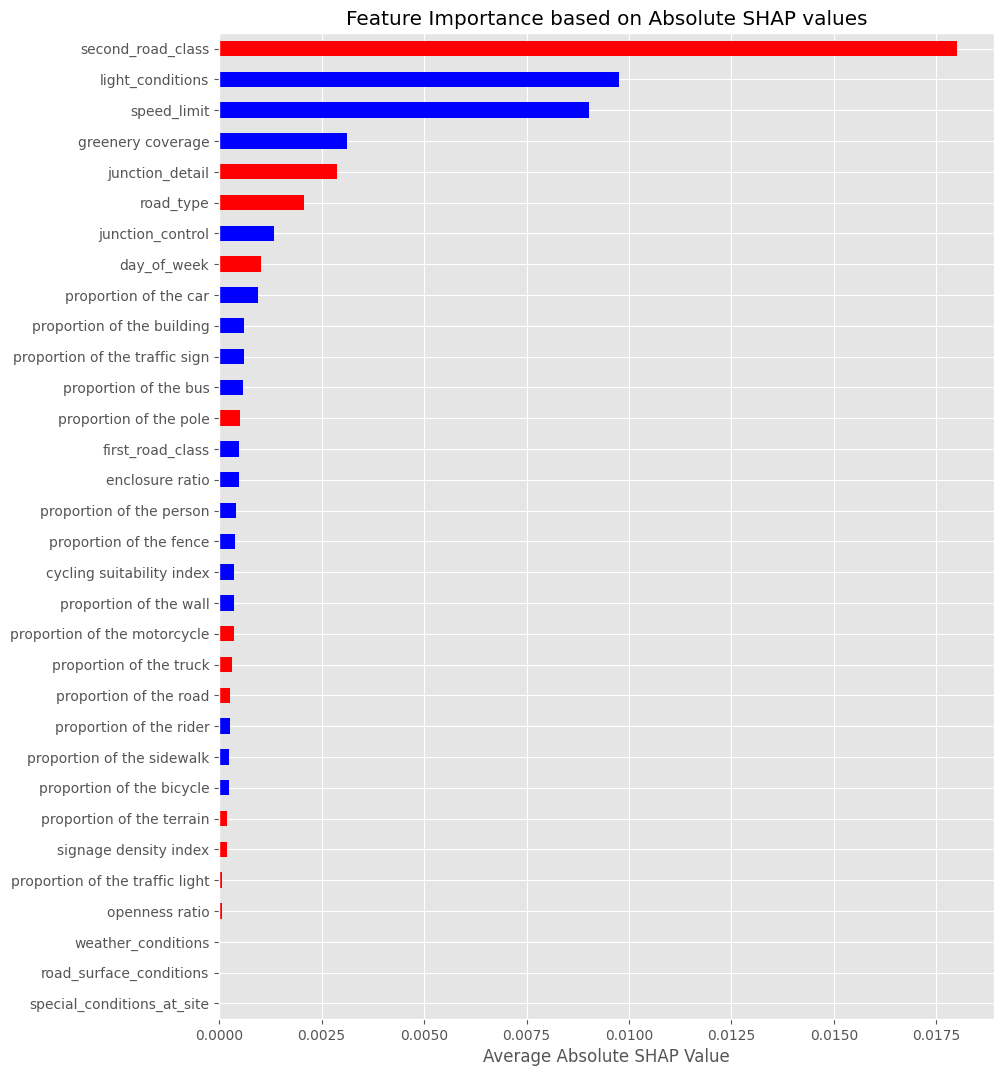

1. special_conditions_at_site
2. road_surface_conditions
3. weather_conditions
4. openness ratio
5. proportion of the traffic light
6. signage density index
7. proportion of the terrain
8. proportion of the bicycle
9. proportion of the sidewalk
10. proportion of the rider
11. proportion of the road
12. proportion of the truck
13. proportion of the motorcycle
14. proportion of the wall
15. cycling suitability index
16. proportion of the fence
17. proportion of the person
18. enclosure ratio
19. first_road_class
20. proportion of the pole
21. proportion of the bus
22. proportion of the traffic sign
23. proportion of the building
24. proportion of the car
25. day_of_week
26. junction_control
27. road_type
28. junction_detail
29. greenery coverage
30. speed_limit
31. light_conditions
32. second_road_class


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 计算每个特征的平均SHAP值
mean_shap_values = positive_class_shap_values.mean(axis=0)

# 使用SHAP值的绝对值对特征进行排序
feature_names = combined_features.columns
shap_importance_abs = pd.Series(np.abs(mean_shap_values), index=feature_names).sort_values(ascending=True)
shap_importance_original = pd.Series(mean_shap_values, index=feature_names).loc[shap_importance_abs.index]

# 创建颜色列表：正值为红色，负值为蓝色
colors = ['red' if value > 0 else 'blue' for value in shap_importance_original]

# 绘制柱形图
plt.figure(figsize=(10, len(feature_names) * 0.4))  # 调整图像大小
shap_importance_abs.plot(kind='barh', color=colors)
plt.xlabel('Average Absolute SHAP Value')
plt.title('Feature Importance based on Absolute SHAP values')
plt.show()

# 获得特征排序名单
sorted_feature_names = shap_importance_abs.index.tolist()

# 打印特征排序名单
for rank, feature in enumerate(sorted_feature_names, 1):
    print(f"{rank}. {feature}")


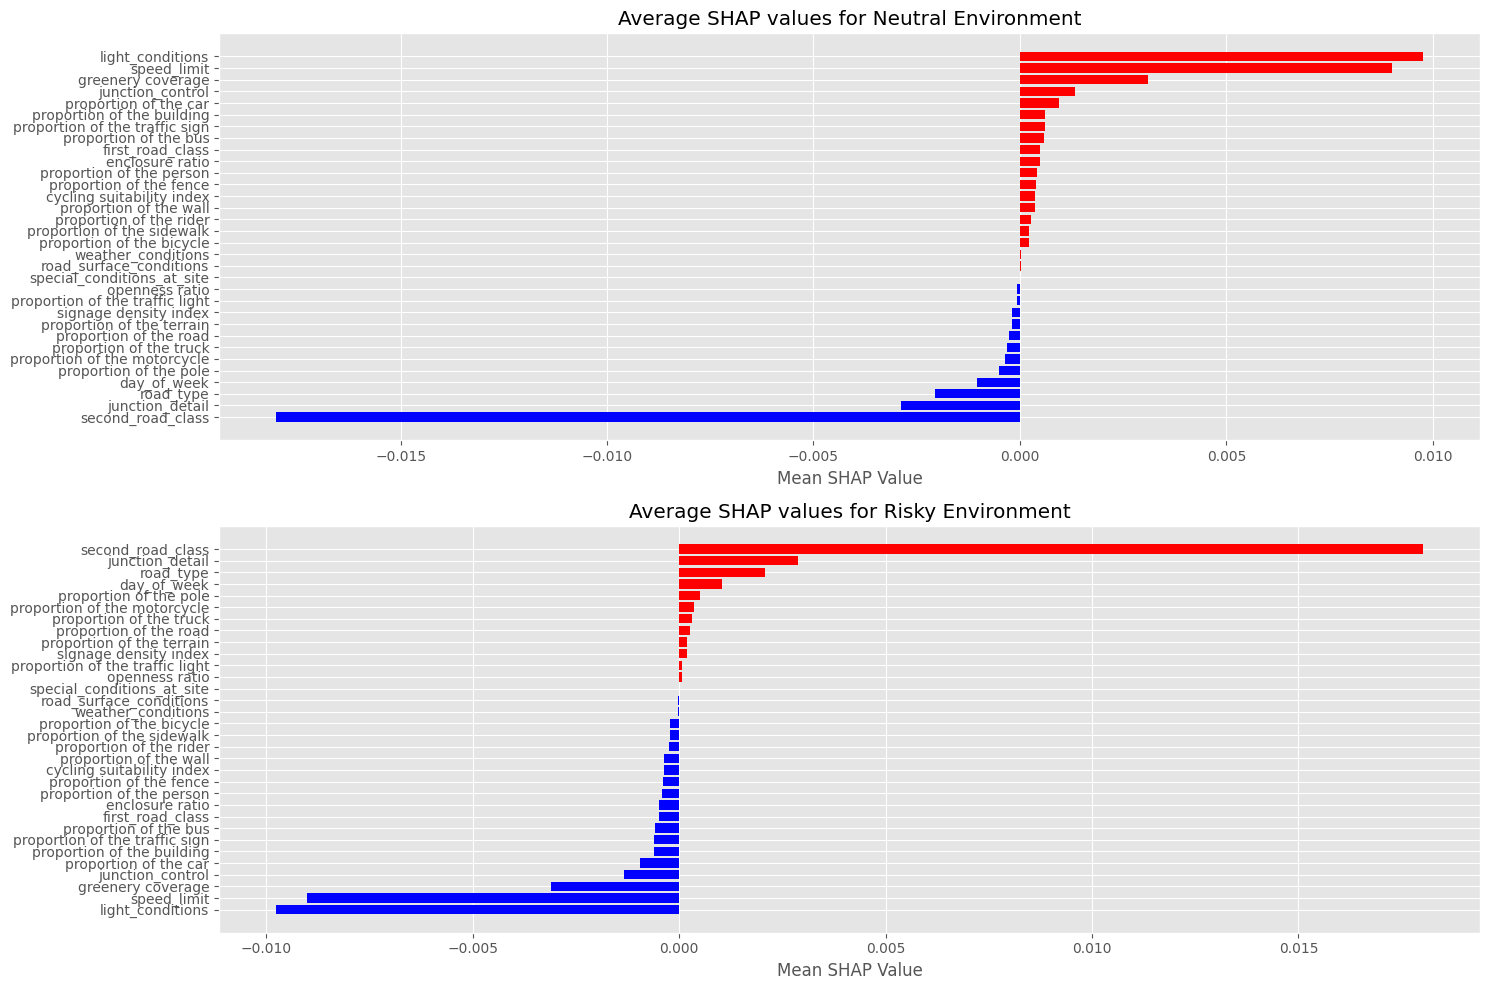

In [ ]:
# 计算每个特征的平均SHAP值
mean_shap_values_class2 = np.mean(shap_values[0], axis=0)
mean_shap_values_class3 = np.mean(shap_values[1], axis=0)

# 对每个特征的平均SHAP值进行排序
sorted_indices_class2 = np.argsort(mean_shap_values_class2)
sorted_indices_class3 = np.argsort(mean_shap_values_class3)

# 根据SHAP值的正负决定颜色
colors_class2 = ['red' if shap_val > 0 else 'blue' for shap_val in mean_shap_values_class2[sorted_indices_class2]]
colors_class3 = ['red' if shap_val > 0 else 'blue' for shap_val in mean_shap_values_class3[sorted_indices_class3]]

# 绘制柱状图
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# 绘制类别2的柱状图
##axs[0].barh(test_x_resampled.columns[sorted_indices_class2], mean_shap_values_class2[sorted_indices_class2], color=colors_class2)
axs[0].barh(combined_features.columns[sorted_indices_class2], mean_shap_values_class2[sorted_indices_class2], color=colors_class2)
axs[0].set_title('Average SHAP values for Neutral Environment')
axs[0].set_xlabel('Mean SHAP Value')

# 绘制类别3的柱状图
##axs[1].barh(test_x_resampled.columns[sorted_indices_class3], mean_shap_values_class3[sorted_indices_class3], color=colors_class3)
axs[1].barh(combined_features.columns[sorted_indices_class3], mean_shap_values_class3[sorted_indices_class3], color=colors_class3)
axs[1].set_title('Average SHAP values for Risky Environment')
axs[1].set_xlabel('Mean SHAP Value')

plt.tight_layout()
plt.show()

## **5.2. SHAP Summary Plot**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


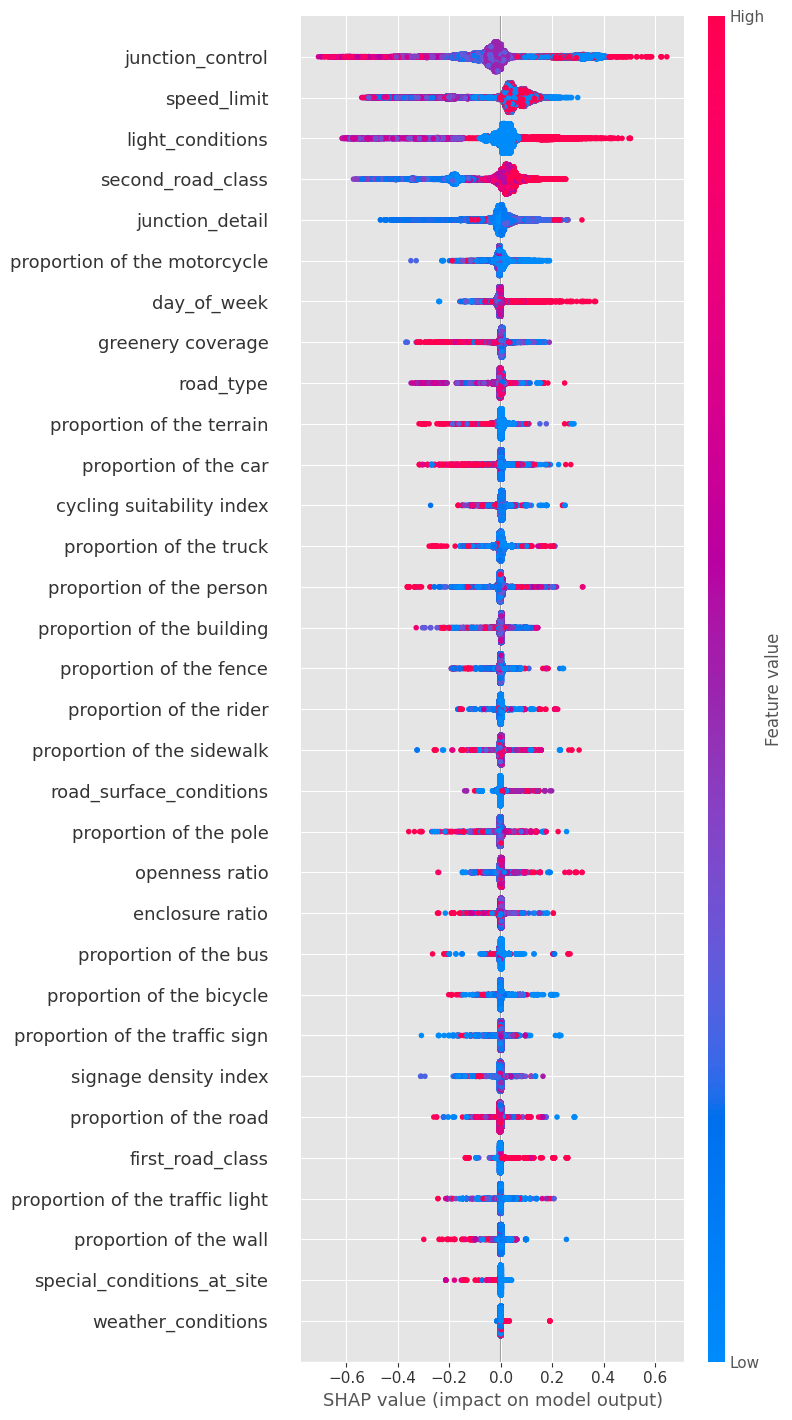

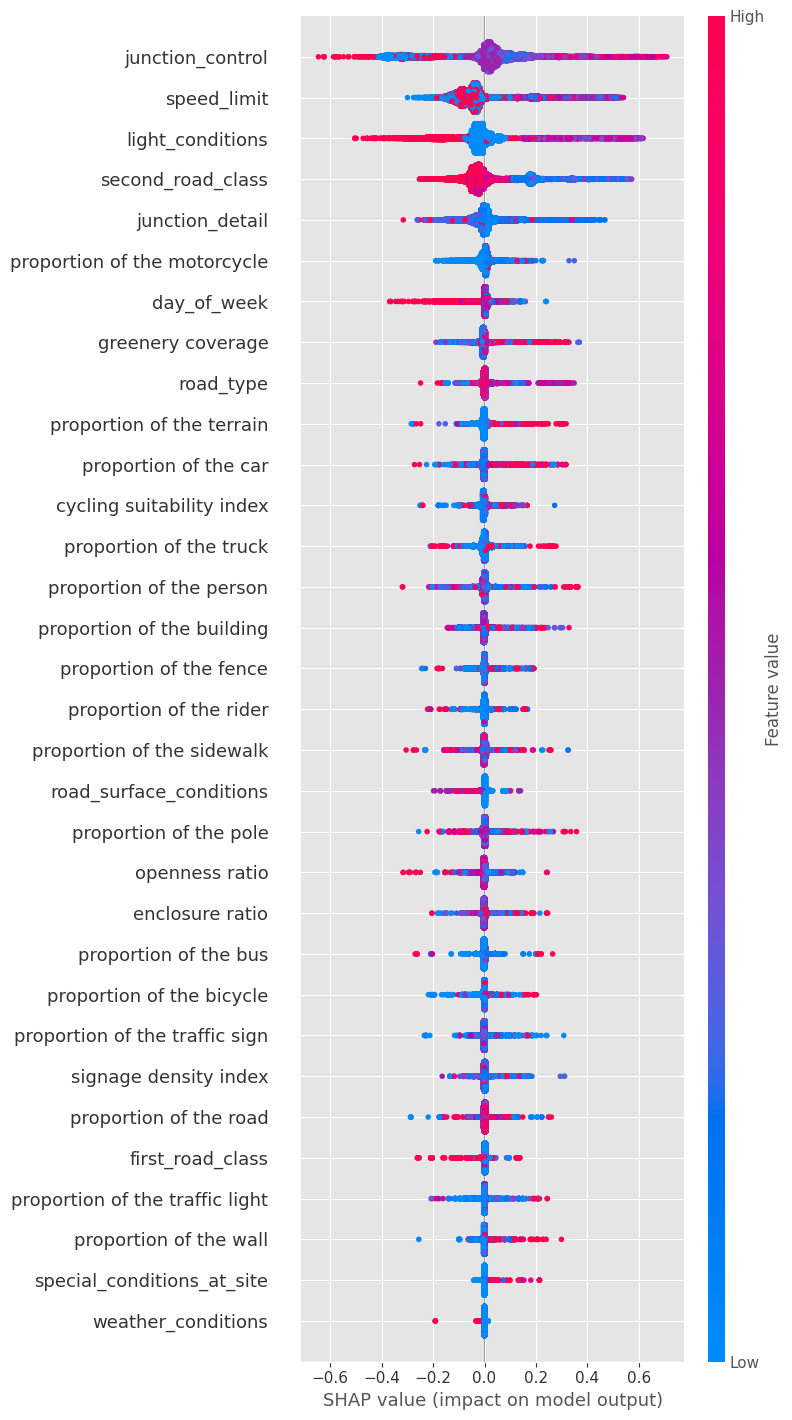

In [ ]:
import shap

# 初始化Tree解释器
explainer = shap.TreeExplainer(dt_final)

# 计算SHAP值
shap_values = explainer.shap_values(combined_features)

# 获取所有特征的数量
num_features = combined_features.shape[1]

# 对于类别2 (假设0索引代表类别2)
shap.summary_plot(shap_values[0], combined_features, max_display=num_features)

# 对于类别3 (假设1索引代表类别3)
shap.summary_plot(shap_values[1], combined_features, max_display=num_features)


## **5.3. SHAP Dependence Plot**

In [ ]:
import shap

# 初始化Tree解释器
explainer = shap.TreeExplainer(dt_final)

combined_features_ori = pd.concat([train_x, test_x], ignore_index=True)
combined_labels_ori = pd.concat([train_y, test_y], ignore_index=True)

# 计算SHAP值
shap_values_ori = explainer.shap_values(combined_features_ori)

# 获取特征名称列表
feature_names_ori = combined_features_ori.columns.tolist()

In [ ]:
# 计算SHAP值
shap_values = explainer.shap_values(combined_features_ori)

# 获取特征名称列表
feature_names = combined_features_ori.columns.tolist()

for feature in feature_names:
    # 对于类别2 (假设0索引代表类别2)
    shap.dependence_plot(feature, shap_values[0], combined_features_ori, display_features=combined_features_ori, show=False)
    plt.title(f"SHAP Dependence Plot for Neutral Environment: {feature}")
    plt.show()

    # 对于类别3 (假设1索引代表类别3)
    shap.dependence_plot(feature, shap_values[1], combined_features_ori, display_features=combined_features_ori, show=False)
    plt.title(f"SHAP Dependence Plot for Risky Environment: {feature}")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt

def custom_dependence_plot(feature_name_ori, shap_values, features, color="blue", point_size=10):
    feature_index = features.columns.get_loc(feature_name)
    plt.scatter(features[feature_name], shap_values[:, feature_index], c=color, alpha=0.3, s=point_size)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(feature_name)
    plt.ylabel("SHAP value for " + feature_name)
    plt.show()

# 计算SHAP值
shap_values = explainer.shap_values(combined_features_ori)

# 对于类别2
for feature_name in combined_features_ori.columns:
    custom_dependence_plot(feature_name, shap_values[0], combined_features_ori)

# 对于类别3
for feature_name in combined_features_ori.columns:
    custom_dependence_plot(feature_name, shap_values[1], combined_features_ori)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt

def custom_dependence_plot(feature_name, shap_values, features, color="blue", point_size=10):
    feature_index = features.columns.get_loc(feature_name)

    # Scatter plot
    plt.scatter(features[feature_name], shap_values[:, feature_index], c=color, alpha=0.3, s=point_size)

    # Fit a linear regression line
    coef = np.polyfit(features[feature_name], shap_values[:, feature_index], 1)
    poly1d_fn = np.poly1d(coef)

    # Add regression line to the plot
    plt.plot(features[feature_name], poly1d_fn(features[feature_name]), '-', color='black')

    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(feature_name)
    plt.ylabel("SHAP value for " + feature_name)
    plt.show()

# Assuming explainer and combined_features_ori are defined and valid
shap_values = explainer.shap_values(combined_features_ori)

# For class 2
for feature_name in combined_features_ori.columns:
    custom_dependence_plot(feature_name, shap_values[0], combined_features_ori)

# For class 3
for feature_name in combined_features_ori.columns:
    custom_dependence_plot(feature_name, shap_values[1], combined_features_ori)

Output hidden; open in https://colab.research.google.com to view.